In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from nltk.tokenize import TweetTokenizer
import time
from torch_scatter import scatter_max, scatter_mean, scatter_std
from sklearn.model_selection import KFold
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import spacy
import string
import os
import re
import math
from torch import nn
from torch.utils.flop_counter import FlopCounterMode
from transformers import AutoModel, DebertaV2Tokenizer, AutoTokenizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
model = AutoModel.from_pretrained("microsoft/deberta-v3-large")

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
id_vocab = {v:k for k,v in tokenizer.vocab.items()}
all_vocab_indices = list(id_vocab.keys())

In [4]:

# all_vocab_str = []
# vector_keys = list(nlp.vocab.vectors.keys())
# for i in range(len(vector_keys)):
#     try:
#         t = nlp.vocab.strings[vector_keys[i]]
#         all_vocab_str.append(t)
#     except:
#         continue

In [5]:
import string
# Create a set of all English characters, numbers, and punctuation
allowed_chars = string.ascii_letters + string.digits + string.punctuation
all_chars = set(allowed_chars)

In [6]:
with open(r'Data\ReducedEmbeddings\deberta_larg_reduced_embeddings_64.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
all_vocab_str = []
for i in range(len(id_vocab)):
    all_vocab_str.append(id_vocab[i])
    
# embeddings = (embeddings - torch.min(embeddings)) / (torch.max(embeddings)-torch.min(embeddings))
token_vocab_dict = dict(zip(all_vocab_str, embeddings))
# del all_vocab_str
# del all_vocab_doc

In [7]:
with open(r'Data\ReducedEmbeddings\polarity_debertav3_tokens_gpt_mini_emb.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)

128001

In [8]:
polarities_subjectivities.shape

torch.Size([128001, 2])

In [9]:
for i in range(len(all_vocab_str)):
    if 'nice' in all_vocab_str[i]:
        print(i, polarities_subjectivities[i])
        break

1085 tensor([0.7000, 0.6000], dtype=torch.float64)


In [10]:
import string
# Create a set of all English characters, numbers, and punctuation
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' \t'
all_chars = set(allowed_chars)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 50
folder_path = r'data\TextClassification\review_polarity'
# t_tokenizer = TweetTokenizer()
device

device(type='cuda')

In [12]:
def load_dataset(dataset_path, shuffle = False):
    pos_path = os.path.join(dataset_path, 'pos')
    neg_path = os.path.join(dataset_path, 'neg')
    pos_names = os.listdir(pos_path)
    neg_names = os.listdir(neg_path)
    df = []
    for pname in pos_names:
        file_path = os.path.join(pos_path, pname)
        with open(file_path, 'rt', encoding='utf8') as f:
            df.append([1, f.read()])
    
    for nname in neg_names:
        file_path = os.path.join(neg_path, nname)
        with open(file_path, 'rt', encoding='utf8') as f:
            df.append([0, f.read()])
    df = pd.DataFrame(data=df, columns=['label', 'text'])
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    return df

In [13]:
keep_ratio = 1.0
df = load_dataset(r'Data\TextClassification\review_polarity')
# df.text = df.text.apply(lambda d: d[:50])
df.dropna(inplace=True)
df = df.iloc[:int(keep_ratio*df.shape[0])]
target_classes = ["Negative", "Positive"]
df.shape

(2000, 2)

In [14]:
doc_lengths = np.array([len(df.text[i]) for i in df.index])
print(np.max(doc_lengths))

14957


In [15]:
class_list = df.label.unique()
class_id = {target_classes[i]:i for i in class_list}
id_class = {i:target_classes[i] for i in class_list}

In [16]:
char_set = set()
for doc in df.text.values:
    char_set.update(set(' '.join(tokenizer.tokenize(doc))))
len(char_set)

69

In [17]:
# vocab_dict = {c:i for i, c in enumerate(allowed_chars)}
# if '\x01' not in vocab_dict:
#     vocab_dict['\x01'] = len(vocab_dict)
# char_Set = set(vocab_dict.keys())
# len(char_Set)

In [18]:
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
all_chars = set(''.join(char_set).join(allowed_chars))
vocab_dict = {c:i for i, c in enumerate(all_chars)}
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())
num_embedding = len(vocab_dict)
vocab_dict_rev = dict(zip(list(vocab_dict.values()), list(vocab_dict.keys())))

In [19]:
class KFoldCharacterandTokenLevelDataset(Dataset):
    
    def __init__(self, X, y, num_classes, char_dict, token_dict, sentiment_dict, tokenizer, shuffle=True, batch_size=128, k_folds=10, fold_idx=0) -> None:
        super().__init__()
        self.fold_idx = fold_idx
        kf = KFold(k_folds, shuffle=True, random_state=911)
        self.k_folds = list(kf.split(np.arange(len(y))))
        self.k_folds = [(np.array(f[0], dtype=np.longlong), np.array(f[1], dtype=np.longlong)) for f in self.k_folds]
        
        if batch_size > len(y)//k_folds:
            batch_size = len(y)//k_folds
        self.batch_size = batch_size
        
        if len(y) % batch_size*k_folds != 0:
            
            self.shortage = ((len(y) // (batch_size*k_folds))+1)*(batch_size*k_folds) - len(y)
            print(f"!!!! This amount of data added: {self.shortage}, change batch size or k-fold to reduce it!")
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            y = np.concatenate([y, empty_labels])
            X = np.concatenate([X, empty_strings])
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        # self.token_dict = token_dict
        self.sentiment_dict = sentiment_dict
        self.max_token_count = 0
        
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            # tokens = self.tokenizer(''.join(c for c in doc if c in self.char_Set))
            # tokens = [t.text for t in tokens]
            tokens = self.tokenizer(doc)
            # tokens = [t for t in tokens if t in token_dict]
            if len(tokens) == 0:
                tokens = ['empty']
                            
            token_lengths = [len(t) for t in tokens]
            tokens.append('\x01')
            token_embs = [token_dict[t] if t in token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
            token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
            doc = ' '.join(tokens)
            
            token_lengths.append(len(tokens[-1])-1)
            token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
            # token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
            token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
            # token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
            token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
            doc = ' '.join(tokens)
            characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
            token_positions = torch.arange(len(token_lengths), dtype=torch.long)
            token_indices = torch.repeat_interleave(token_positions, token_lengths)
            num_tokens = len(token_lengths)
            if num_tokens > self.max_token_count:
                self.max_token_count = num_tokens
            g_data = Data(x=characters,
                            token_positions=token_positions,
                            character_length = len(characters),
                            num_tokens = num_tokens,
                            token_indices=token_indices,
                            token_lengths=token_lengths,
                            token_embeddings=token_embs,
                            token_sentiments=token_sentiments
                            )
            self.all_data.append(g_data)
            
        self.all_data = Batch.from_data_list(self.all_data)
        self.update_split(self.fold_idx)
        
    def update_split(self, fold_idx):
        self.active_fold = self.k_folds[fold_idx]
        
        self.train_y = self.y[self.active_fold[0]]
        self.test_y = self.y[self.active_fold[1]]
        
        self.all_train_data = self.all_data[self.active_fold[0]]
        self.all_test_data = self.all_data[self.active_fold[1]]
        self.train()
        
    def train(self):
        self.update_sections(self.train_y, self.all_train_data)
        self.is_train=True
        
    def eval(self):
        self.update_sections(self.test_y, self.all_test_data)
        self.is_train=False
        
    def update_sections(self, y, all_data):
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([all_data[i].character_length[0] for i in range(len(all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return self.sections, self.section_size, self.x_len_args, self.x_lengths, self.num_sections
        
    def __getitem__(self, index):
        index = self.get_section_index(index+1)
        if self.is_train:
            return self.all_train_data[index], self.train_y[index]
        else:
            return self.all_test_data[index], self.test_y[index]
    
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self, index):
        position_j = index % self.section_size
        section_i = (index //self.section_size) % self.num_sections
        target_index = self.sections[section_i, position_j]
        
        # self.position_j = (self.position_j + 1) % self.section_size
        # if self.position_j == 0:
        #     self.section_i = (self.section_i + 1) % self.num_sections
        #     if self.shuffle and self.section_i == 0:
        #         self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return target_index 
    
    # def get_section_index(self):
    #     target_index = self.sections[self.section_i, self.position_j]
        
    #     self.position_j = (self.position_j + 1) % self.section_size
    #     if self.position_j == 0:
    #         self.section_i = (self.section_i + 1) % self.num_sections
    #         if self.shuffle and self.section_i == 0:
    #             self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
    #     return target_index    

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
                
        return np.array(groups), groups_size
        

In [20]:
class TrainTestDatasetWrapper(Dataset):
    
    def __init__(self, target_dataset, is_train=True) -> None:
        super().__init__()
        self.dataset = target_dataset
        self.is_train = is_train
    
    def __getitem__(self, index):
        if self.is_train:
            if not self.dataset.is_train:
                self.dataset.train()
            return self.dataset[index]
        else:
            if self.dataset.is_train:
                self.dataset.eval()
            return self.dataset[index]
    
    def set_active_fold(self, fold_idx):
        self.dataset.update_split(fold_idx)
    
    def reset_params(self):
        self.dataset.reset_params()
        
    def __len__(self):
        if self.is_train:
            return len(self.dataset.train_y)
        else:
            return len(self.dataset.test_y)

In [21]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [22]:
# def double_tokenizer(doc):
#     tokens = t_tokenizer.tokenize(doc)
#     tokens = nlp(' '.join(tokens))
#     tokens = [t.text for t in tokens]
#     return tokens

# def nlp_tokenizer(doc):
#     tokens = nlp(doc)
#     tokens = [t.text for t in tokens]
#     return tokens

In [23]:
tokens = tokenizer.tokenize(df.text[0])

In [24]:
'have' in token_vocab_dict

True

In [25]:
[t for t in tokens if t not in token_vocab_dict]

[]

In [26]:
main_dataset = KFoldCharacterandTokenLevelDataset(df.text.values, df.label.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, batch_size=batch_size, shuffle=False)
batch_size = main_dataset.batch_size

100%|██████████| 2000/2000 [01:12<00:00, 27.50it/s]


In [27]:
train_dataset = TrainTestDatasetWrapper(main_dataset, True)
test_dataset = TrainTestDatasetWrapper(main_dataset, False)
train_dataset.set_active_fold(0)
test_dataset.set_active_fold(0)
# max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

In [28]:
train_dataset[0]

(Data(x=[9149], token_positions=[1581], character_length=[1], num_tokens=[1], token_indices=[9149], token_lengths=[1581], token_embeddings=[1581, 64], token_sentiments=[1581, 2]),
 tensor([0., 1.]))

In [29]:
train_lengths = np.array([train_dataset[i][0].num_tokens for i in range(len(train_dataset))])
test_lengths = np.array([test_dataset[i][0].num_tokens for i in range(len(test_dataset))])
print(np.max(train_lengths))
print(np.max(test_lengths))

3080
2804


In [30]:
X, y = next(iter(test_dataloader))

In [31]:
test_dataset[0]

(Data(x=[8786], token_positions=[1576], character_length=[1], num_tokens=[1], token_indices=[8786], token_lengths=[1576], token_embeddings=[1576, 64], token_sentiments=[1576, 2]),
 tensor([0., 1.]))

In [32]:
df.iloc[np.argwhere(['hardy' in c and 'obscure' in c for c in  df.text.values]).squeeze()]

label                                                    1
text     no , i did not read the novel by thomas hardy ...
Name: 131, dtype: object

In [33]:
for i in range(15,20):
    char_ids = X[i].x
    text_for_ids = ''.join([vocab_dict_rev[ci.item()] for ci in char_ids])
    print(torch.argmax(y[i]).item(), text_for_ids)

0 ▁the ▁happy ▁bastard ' s ▁quick ▁movie ▁review ▁wild ▁wild ▁west ▁a ▁better ▁name ▁for ▁this ▁movie ▁might ' ve ▁been ▁" ▁wild ▁wild ▁waste ▁" ▁. ▁war ner ▁bros ▁. ▁, ▁in ▁an ▁attempt ▁to ▁get ▁their ▁own ▁men ▁in ▁black ▁style ▁of ▁movie ▁, ▁had ▁managed ▁to ▁lasso ▁in ▁some ▁big ▁names ▁( ▁actor ▁will ▁smith ▁and ▁director ▁bar ry ▁son n enfeld ▁, ▁the ▁duo ▁behind ▁mi b ' s ▁success ▁) ▁in ▁order ▁to ▁get ▁their ▁own ▁fourth ▁of ▁july ▁blockbuster ▁, ▁a ▁contemporary ▁big - screen ▁update ▁to ▁the ▁classic ▁western / sci - fi ▁series ▁the ▁wild ▁wild ▁west ▁starring ▁robert ▁con rad ▁. ▁but ▁somehow ▁, ▁they ▁ran ▁into ▁a ▁problem ▁along ▁the ▁way ▁. ▁they ▁were ▁so ▁busy ▁trying ▁to ▁fill ▁specific ▁roles ▁that ▁they ▁forgot ▁one ▁in ▁general ▁that ▁would ' ve ▁made ▁all ▁the ▁difference - ▁a ▁story ▁writer ▁. ▁wild ▁wild ▁west ' s ▁story ▁and ▁script ▁was ▁compiled ▁by ▁six ▁different ▁people ▁, ▁rather ▁than ▁just ▁the ▁one ▁who ▁put ▁the ▁brilliant ▁touches ▁on ▁men ▁in ▁black

In [34]:
sample_rand = torch.randn((64, 1024))

In [35]:
sample_rand.var(unbiased=True)

tensor(1.0027)

In [36]:
X

DataBatch(x=[231269], token_positions=[41047], character_length=[50], num_tokens=[50], token_indices=[231269], token_lengths=[41047], token_embeddings=[41047, 64], token_sentiments=[41047, 2], batch=[231269], ptr=[51], cumulative_token_indices=[231269])

In [37]:
train_tensor = torch.randn((len(X.token_positions), 32))

In [38]:
torch.repeat_interleave(torch.arange(len(X.num_tokens)), X.num_tokens).shape

torch.Size([41047])

In [39]:
X.token_positions

tensor([   0,    1,    2,  ..., 2010, 2011, 2012])

In [40]:
train_tensor

tensor([[ 0.7831,  0.7512,  0.6977,  ..., -1.1602, -0.3615, -0.5455],
        [-0.7509,  0.6035,  2.0883,  ...,  1.0910, -0.8974, -1.2439],
        [-0.6204,  0.6175, -1.2267,  ..., -0.8387,  0.1301,  0.6514],
        ...,
        [-0.1250,  1.7509, -0.9180,  ..., -0.0702, -0.0232,  0.1732],
        [-0.3705,  1.2373,  0.0832,  ...,  1.3734,  1.0569, -0.5330],
        [ 0.7270, -0.8648, -0.6644,  ..., -0.0485, -0.5255,  1.2598]])

In [41]:
from torch_geometric.nn import GATv2Conv, SimpleConv

# Normalization on each feature of all tokens, for this we used batch norm class but with tokens at batch dimention
class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4, add_self_loops=False)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        
    def forward(self, x, edge_data, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, edge_data, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x.T).T)
        x1 = F.leaky_relu_(self.bn1(x1))
        x = torch.cat([x1, x2], dim=1)
        return x, edge_weights

In [42]:
sample_t = torch.randn((400, 5))
sample_t.shape
print(torch.mean(sample_t, dim=0))
print(torch.std(sample_t, dim=0))
bn1 = nn.BatchNorm1d(5)
print(torch.mean(bn1(sample_t), dim=0).detach())
print(torch.std(bn1(sample_t), dim=0).detach())

tensor([-0.0228, -0.0069,  0.0025,  0.0585,  0.0216])
tensor([1.0102, 1.0420, 0.9936, 0.9855, 0.9996])
tensor([ 2.3842e-08,  1.8477e-08, -9.5367e-09, -8.3447e-09, -6.8545e-09])
tensor([1.0012, 1.0012, 1.0012, 1.0012, 1.0012])


In [43]:
# from copy import copy, deepcopy
# gcnn_model = GCNN(64)
# flopt_counter = FlopCounterMode(gcnn_model)
# X.edge_index = torch.randint(0, len(X.token_positions), size=(2,200))
# with flopt_counter:
#     x_input = deepcopy(torch.randn((len(X.token_positions), 64)))
#     edge_data = deepcopy(X.edge_index)
#     gcnn_model(x_input, edge_data)

In [44]:
import networkx as nx
from torch_geometric.utils import to_networkx, to_undirected

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2, seed=-1):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_index = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_coutns )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_coutns, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_index[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_index[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
        
    def re_gen_graph(self, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2, seed=-1):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
            
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2, seed=-1):
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        if v_n_e_counts>0:
            important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        else:
            important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

        important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
        important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
         
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance, seed=-1):
        if seed>-1:
            torch.manual_seed(seed)
        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_index, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_index[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)

In [81]:
class Sentiment_Injection(nn.Module):
    
    def __init__(self, hidden_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)        
        self.conv1 = nn.Conv1d(2, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim*2, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x, token_sentiments):
        x1 = F.relu_(self.bn1(self.conv1(token_sentiments.T).T))
        x = F.relu_(self.conv2(torch.cat([x, x1], dim=1).T))
        # x = x + x1
        return x.T

In [82]:
# sentiment1  = Sentiment_Injection(64)
# sentiment1(torch.ones((41047, 64)), torch.ones((41047, 2))).shape

In [83]:
from torch_geometric.nn import GATv2Conv, SimpleConv, summary

class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, pos_emb_size=8192, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, use_token_polarity=[False, False, False], *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.pos_emb_size = pos_emb_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.use_token_polarity = use_token_polarity
        if seed>-1:
            torch.manual_seed(seed)
 
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        self.dropout = nn.Dropout(p=dropout)

        self.positional_encoding = nn.Embedding(pos_emb_size, embedding_dim)
        self.positional_encoding.weight = self.create_positional_encoding()

        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        
        if self.use_token_polarity[0]:
            self.conv3 = nn.Conv1d(2*hidden_dim + 2, hidden_dim, kernel_size=3, padding=1)
        else:
            self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        if self.use_token_polarity[1]:
            self.sentiment1  = Sentiment_Injection(hidden_dim)
        if self.use_token_polarity[2]:
            self.sentiment2  = Sentiment_Injection(hidden_dim)
            
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(hidden_dim+inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 4
        self.fc0 = nn.Linear(hidden_dim , hidden_dim+inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim+inject_embedding_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
        self.max_length = 0
    
    def forward(self, g_data):
            
        x = self.embedding(g_data.x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

        if self.use_token_polarity[0]:
            x = torch.cat([x1, x2, g_data.token_sentiments.T], dim=0)
        else:
            x = torch.cat([x1, x2], dim=0)
            
        x = F.relu(self.conv3(x)).T
        
        if self.use_token_polarity[1]:
            x = self.sentiment1(x, g_data.token_sentiments)
            
        x = x + self.positional_encoding(g_data.token_positions)

        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
            
        graph = self.graph_generator.gen_graph(x, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1
        lattice_edges = lattice_edges-1
        
        
        doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
        x, edge_weights = self.gcnn1(graph.x, graph.edge_index, return_attention_weights = True)
        edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        
        if self.use_token_polarity[2]:
            x = self.sentiment2(x, g_data.token_sentiments)
            
        x = torch.cat([graph.x[:g_data.token_embeddings.shape[0]], g_data.token_embeddings], dim=1)
        x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        x, edge_weights = self.gcnn2(x, graph.edge_index)

        x = F.elu_(self.fc1(x))
        x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(g_data.token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x


    def create_positional_encoding(self):
        position = torch.arange(self.pos_emb_size).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
        pe = torch.zeros(self.pos_emb_size, self.hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return torch.nn.Parameter(pe, requires_grad=False)

In [84]:
# for p1 in [False, True]:
#     for p2 in [False, True]:
#         for p3 in [False, True]:
# print(f'\n{p1}, {p2}, {p3}: \n')
classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=64, embedding_dim=64, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=911, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_token_polarity=[False, True, True]).eval()
flopt_counter = FlopCounterMode(classifier_torch_model)
with flopt_counter:
    classifier_torch_model(X)


Module                       FLOP    % Total
------------------------  -------  ---------
CNN_for_Text              31.956B    100.00%
 - aten.convolution       27.583B     86.32%
 - aten.addmm              4.373B     13.68%
 CNN_for_Text.conv1        9.473B     29.64%
  - aten.convolution       9.473B     29.64%
 CNN_for_Text.conv2        9.473B     29.64%
  - aten.convolution       9.473B     29.64%
 CNN_for_Text.conv3        2.018B      6.31%
  - aten.convolution       2.018B      6.31%
 CNN_for_Text.sentiment1   2.049B      6.41%
  - aten.convolution       2.049B      6.41%
 CNN_for_Text.gcnn1        0.841B      2.63%
  - aten.addmm             0.336B      1.05%
  - aten.convolution       0.504B      1.58%
 CNN_for_Text.sentiment2   2.049B      6.41%
  - aten.convolution       2.049B      6.41%
 CNN_for_Text.fc0          0.000B      0.00%
  - aten.addmm             0.000B      0.00%
 CNN_for_Text.gcnn2        3.363B     10.52%
  - aten.addmm             1.345B      4.21%
  - aten.c

In [71]:
# next(iter(classifier_torch_model.parameters())).device

In [72]:

class CnnGnnClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CnnGnnClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [73]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [74]:
# Fardin Rastakhiz @ 2023
from abc import ABC, abstractmethod
from typing import List, Optional

import torch
import lightning as L
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import Logger, CSVLogger
from lightning.pytorch.tuner import Tuner
from typing import List
from pytorch_lightning.core.saving import save_hparams_to_yaml

class ModelManager(ABC):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 max_epochs = 100,
                 ckpt_path: str|None=None,
                 accumulate_grad_batches=1):
        self.torch_model = torch_model
        self.lightning_model = lightning_model
        self.log_dir = log_dir
        self.log_name = log_name
        self.model_save_dir = model_save_dir
        self.device = device
        self.accelerator = 'cpu' if self.device=='cpu' else 'gpu'
        self.max_epochs = max_epochs
        self.ckpt_path = ckpt_path

        self.logger = self._create_logger()
        self.callbacks = self._create_callbacks()
        self.trainer: L.Trainer = self._create_trainer(accumulate_grad_batches)
        self.tuner = Tuner(self.trainer)
        self.tuning_result = None

    def tune(self, data_manager=None, train_dataloaders=None, val_dataloaders=None, datamodule=None, draw_result=True, min_lr=0.0000001, max_lr=0.1):
        self.tuning_result = self.tuner.lr_find(self.lightning_model, datamodule=data_manager, train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders, min_lr=min_lr,max_lr=max_lr, num_training=150)
        if draw_result:
            fig = self.tuning_result.plot(suggest=True)
            fig.show()
        self.update_learning_rate(self.tuning_result.suggestion())
        return self.tuning_result.suggestion()
    
    def update_learning_rate(self, lr):
        self.lightning_model.update_learning_rate(lr)

    def fit(self, train_dataloaders=None, val_dataloaders=None, datamodule=None, max_epochs = -1, ckpt_path=None):
        if ckpt_path is not None and ckpt_path != '':
            self.ckpt_path = ckpt_path
        if max_epochs>0:
            self.trainer.fit_loop.max_epochs = max_epochs
            # self.max_epochs = max_epochs
            # self.trainer = self._create_trainer()
        self.trainer.fit(self.lightning_model,
                         datamodule=datamodule,
                         train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders,
                         ckpt_path = self.ckpt_path
                         )

    def validate(self, dataloaders=None, datamodule=None):
        return self.trainer.validate(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def predict(self, dataloaders=None, datamodule=None):
        return self.trainer.predict(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def _create_trainer(self, accumulate_grad_batches) -> L.Trainer:
        return L.Trainer(
            callbacks=self.callbacks,
            max_epochs=self.max_epochs,
            accelerator=self.accelerator,
            logger=self.logger,
            num_sanity_val_steps=0,
            default_root_dir=self.model_save_dir,
            accumulate_grad_batches=accumulate_grad_batches
        )

    @abstractmethod
    def _create_callbacks(self) -> List[Callback]:
        pass

    def _create_logger(self) -> Logger:
        return CSVLogger(save_dir=self.log_dir, name=self.log_name)

    @abstractmethod
    def draw_summary(self, dataloader):
        pass

    @abstractmethod
    def plot_csv_logger(self, loss_names, eval_names):
        pass
    
    def save_hyper_parameters(self):
        mhparams = {
            'start_lr': 0.045,
            'ckpt_lrs' :  {51: 0.002, 65: 0.00058},
            'last_lr' : 0.0003,
            'ac_loss_factor': 0.0002,
            'weight_decay': 0.0012
        }
        save_hparams_to_yaml(config_yaml=r'logs\hetero_model_17_AG\version_12\hparams.yaml',
                     hparams=mhparams)
        
    # def find_best_settings(data_manager,
    #                        lrs: List[float]=[0.001], dropouts: List[float]=[0.2], 
    #                        weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], 
    #                        batch_sizes: List[int]=[128], log_name='find_best_settings'):
    #     for lr in lrs:
    #         for dropout in dropouts:
    #             for wd in weight_decays:
    #                 for emb_factor in emb_factors:
    #                     for bs in batch_sizes:
    #                         data_manager.update_batch_size(bs)
    #                         torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 128, dropout=dropout)
    #                         lightning_model = HeteroBinaryLightningModel(torch_model,
    #                                         torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
    #                                             loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
    #                                             learning_rate=lr,
    #                                             batch_size=bs,
    #                                             user_lr_scheduler=True
    #                                             ).to(device)
    #                         model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
    #                         model_manager.fit(datamodule=data_manager)
    #                         model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}_{bs}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [75]:
# Fardin Rastakhiz @ 2023
import torch
# from scripts.managers.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from os import path

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

import lightning as L

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100,
                 accumulate_grad_batches=1):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch, accumulate_grad_batches=accumulate_grad_batches)

    def _create_callbacks(self) -> List[Callback]:
        return [
            ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.lightning_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        # if(give_hinge_loss):
        #     print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def evaluate_best_models(self, lightning_type: L.LightningModule, eval_dataloader,
                             give_confusion_matrix: bool=True, 
                             give_report: bool=True, 
                             give_f1_score: bool=False, 
                             give_accuracy_score: bool=False, 
                             give_precision_score: bool=False, 
                             give_recall_score: bool=False, 
                             give_hinge_loss: bool=False,
                             multi_class: bool=False, **kwargs):
        self.lightning_model = lightning_type.load_from_checkpoint(rf'{self.trainer.checkpoint_callback.best_model_path}', map_location=None, hparams_file=None, strict=True, **kwargs).eval()
        self.save_evaluation(eval_dataloader, 'best_model', give_confusion_matrix, give_report,
                             give_f1_score, give_accuracy_score, give_precision_score, give_recall_score, give_hinge_loss, multi_class)
            
    def save_evaluation(self, eval_dataloader, name_prepend: str='',
                    give_confusion_matrix: bool=True, 
                    give_report: bool=True, 
                    give_f1_score: bool=False, 
                    give_accuracy_score: bool=False, 
                    give_precision_score: bool=False, 
                    give_recall_score: bool=False, 
                    give_hinge_loss: bool=False,
                    multi_class: bool=False
                    ):
            
            test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
            
            y_true = []
            y_pred = []
            self.lightning_model.eval()
            self.lightning_model.model.eval()
            self.torch_model.eval()
            self.trainer.model.eval()
            for X, y in eval_dataloader:
                with torch.no_grad():
                    y_p = self.lightning_model(X.to(self.device))
                if type(y_p) is tuple:
                    y_p = y_p[0]
                
                if multi_class:
                    y_pred.append(y_p.detach().to(y.device))
                    y_true.append(y)
                else:
                    y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                    y_true.append(y.to(torch.int32))
                    
            y_true = torch.concat(y_true)
            y_pred = torch.concat(y_pred)
            print(y_true.shape)
            print(y_pred.shape)
            if multi_class:
                y_true_num = torch.argmax(y_true, dim=1)
                y_pred_num = torch.argmax(y_pred, dim=1)
            else:
                y_true_num = y_true
                y_pred_num = y_pred
                
            print(y_true_num.shape)
            print(y_pred_num.shape)
            with open(test_metrics_path, 'at+') as f:
                if(give_confusion_matrix):
                    print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
                if(give_report):
                    print(classification_report(y_true_num, y_pred_num), file=f)
                if(give_f1_score):
                    if multi_class:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
                if(give_accuracy_score):
                    print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
                if(give_precision_score):
                    if multi_class:
                        print(f'precision: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'precision: {precision_score(y_true_num, y_pred_num)}', file=f)
                if(give_recall_score):
                    if multi_class:
                        print(f'recall: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'recall: {recall_score(y_true_num, y_pred_num)}', file=f)
                # if(give_hinge_loss):
                #     print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)

In [76]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [77]:
# output_size = 32
# hidden_dim = 16
# embedding_dim = 16
# label_size = 1
# seed = 911

In [78]:
# for i in range(10):
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True, use_token_polarity=[False, True, True]):
    torch.autograd.set_detect_anomaly(True)
    classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_token_polarity=use_token_polarity).to(device)
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name=f'CNN-GNN_{use_token_polarity[0]}_{use_token_polarity[1]}_{use_token_polarity[2]}',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CnnGnnClassifierLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [79]:
torch.cuda.empty_cache()
import gc
gc.collect()

132

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generat

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8283    0.8454    0.8367        97
           1     0.8515    0.8350    0.8431       103

    accuracy                         0.8400       200
   macro avg     0.8399    0.8402    0.8399       200
weighted avg     0.8402    0.8400    0.8400       200

confusion matrix:
 tensor([[82, 15],
        [17, 86]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.73it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8961    0.7113    0.7931        97
           1     0.7724    0.9223    0.8407       103

    accuracy                         0.8200       200
   macro avg     0.8342    0.8168    0.8169       200
weighted avg     0.8324    0.8200    0.8176       200

confusion matrix:
 tensor([[69, 28],
        [ 8, 95]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.58it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8961    0.7113    0.7931        97
           1     0.7724    0.9223    0.8407       103

    accuracy                         0.8200       200
   macro avg     0.8342    0.8168    0.8169       200
weighted avg     0.8324    0.8200    0.8176       200

confusion matrix:
 tensor([[69, 28],
        [ 8, 95]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.23it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8660    0.8485    0.8571        99
           1     0.8544    0.8713    0.8627       101

    accuracy                         0.8600       200
   macro avg     0.8602    0.8599    0.8599       200
weighted avg     0.8601    0.8600    0.8600       200

confusion matrix:
 tensor([[84, 15],
        [13, 88]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.52it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9610    0.7475    0.8409        99
           1     0.7967    0.9703    0.8750       101

    accuracy                         0.8600       200
   macro avg     0.8789    0.8589    0.8580       200
weighted avg     0.8781    0.8600    0.8581       200

confusion matrix:
 tensor([[74, 25],
        [ 3, 98]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9149    0.8687    0.8912        99
           1     0.8774    0.9208    0.8986       101

    accuracy                         0.8950       200
   macro avg     0.8961    0.8947    0.8949       200
weighted avg     0.8959    0.8950    0.8949       200

confusion matrix:
 tensor([[86, 13],
        [ 8, 93]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.24it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8491    0.8654    0.8571       104
           1     0.8511    0.8333    0.8421        96

    accuracy                         0.8500       200
   macro avg     0.8501    0.8494    0.8496       200
weighted avg     0.8500    0.8500    0.8499       200

confusion matrix:
 tensor([[90, 14],
        [16, 80]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.26it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8932    0.8846    0.8889       104
           1     0.8763    0.8854    0.8808        96

    accuracy                         0.8850       200
   macro avg     0.8847    0.8850    0.8849       200
weighted avg     0.8851    0.8850    0.8850       200

confusion matrix:
 tensor([[92, 12],
        [11, 85]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.91it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8421    0.9231    0.8807       104
           1     0.9070    0.8125    0.8571        96

    accuracy                         0.8700       200
   macro avg     0.8745    0.8678    0.8689       200
weighted avg     0.8732    0.8700    0.8694       200

confusion matrix:
 tensor([[96,  8],
        [18, 78]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8298    0.8387    0.8342        93
           1     0.8585    0.8505    0.8545       107

    accuracy                         0.8450       200
   macro avg     0.8441    0.8446    0.8443       200
weighted avg     0.8451    0.8450    0.8451       200

confusion matrix:
 tensor([[78, 15],
        [16, 91]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.03it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8588    0.7849    0.8202        93
           1     0.8261    0.8879    0.8559       107

    accuracy                         0.8400       200
   macro avg     0.8425    0.8364    0.8380       200
weighted avg     0.8413    0.8400    0.8393       200

confusion matrix:
 tensor([[73, 20],
        [12, 95]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.58it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9000    0.7742    0.8324        93
           1     0.8250    0.9252    0.8722       107

    accuracy                         0.8550       200
   macro avg     0.8625    0.8497    0.8523       200
weighted avg     0.8599    0.8550    0.8537       200

confusion matrix:
 tensor([[72, 21],
        [ 8, 99]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9136    0.7629    0.8315        97
           1     0.8067    0.9320    0.8649       103

    accuracy                         0.8500       200
   macro avg     0.8602    0.8475    0.8482       200
weighted avg     0.8585    0.8500    0.8487       200

confusion matrix:
 tensor([[74, 23],
        [ 7, 96]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  7.92it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9600    0.7423    0.8372        97
           1     0.8000    0.9709    0.8772       103

    accuracy                         0.8600       200
   macro avg     0.8800    0.8566    0.8572       200
weighted avg     0.8776    0.8600    0.8578       200

confusion matrix:
 tensor([[ 72,  25],
        [  3, 100]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8738    0.9278    0.9000        97
           1     0.9278    0.8738    0.9000       103

    accuracy                         0.9000       200
   macro avg     0.9008    0.9008    0.9000       200
weighted avg     0.9016    0.9000    0.9000       200

confusion matrix:
 tensor([[90,  7],
        [13, 90]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.7333    0.9462    0.8263        93
           1     0.9375    0.7009    0.8021       107

    accuracy                         0.8150       200
   macro avg     0.8354    0.8236    0.8142       200
weighted avg     0.8426    0.8150    0.8134       200

confusion matrix:
 tensor([[88,  5],
        [32, 75]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.27it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8675    0.7742    0.8182        93
           1     0.8205    0.8972    0.8571       107

    accuracy                         0.8400       200
   macro avg     0.8440    0.8357    0.8377       200
weighted avg     0.8423    0.8400    0.8390       200

confusion matrix:
 tensor([[72, 21],
        [11, 96]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 10.20it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.6992    0.9247    0.7963        93
           1     0.9091    0.6542    0.7609       107

    accuracy                         0.7800       200
   macro avg     0.8041    0.7895    0.7786       200
weighted avg     0.8115    0.7800    0.7773       200

confusion matrix:
 tensor([[86,  7],
        [37, 70]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.7623    0.9588    0.8493        97
           1     0.9487    0.7184    0.8177       103

    accuracy                         0.8350       200
   macro avg     0.8555    0.8386    0.8335       200
weighted avg     0.8583    0.8350    0.8330       200

confusion matrix:
 tensor([[93,  4],
        [29, 74]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.31it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8438    0.8351    0.8394        97
           1     0.8462    0.8544    0.8502       103

    accuracy                         0.8450       200
   macro avg     0.8450    0.8447    0.8448       200
weighted avg     0.8450    0.8450    0.8450       200

confusion matrix:
 tensor([[81, 16],
        [15, 88]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.7759    0.9278    0.8451        97
           1     0.9167    0.7476    0.8235       103

    accuracy                         0.8350       200
   macro avg     0.8463    0.8377    0.8343       200
weighted avg     0.8484    0.8350    0.8340       200

confusion matrix:
 tensor([[90,  7],
        [26, 77]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.76it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8953    0.7264    0.8021       106
           1     0.7456    0.9043    0.8173        94

    accuracy                         0.8100       200
   macro avg     0.8205    0.8153    0.8097       200
weighted avg     0.8250    0.8100    0.8092       200

confusion matrix:
 tensor([[77, 29],
        [ 9, 85]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8953    0.7264    0.8021       106
           1     0.7456    0.9043    0.8173        94

    accuracy                         0.8100       200
   macro avg     0.8205    0.8153    0.8097       200
weighted avg     0.8250    0.8100    0.8092       200

confusion matrix:
 tensor([[77, 29],
        [ 9, 85]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9342    0.6698    0.7802       106
           1     0.7177    0.9468    0.8165        94

    accuracy                         0.8000       200
   macro avg     0.8260    0.8083    0.7984       200
weighted avg     0.8325    0.8000    0.7973       200

confusion matrix:
 tensor([[71, 35],
        [ 5, 89]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8991    0.8750    0.8869       112
           1     0.8462    0.8750    0.8603        88

    accuracy                         0.8750       200
   macro avg     0.8726    0.8750    0.8736       200
weighted avg     0.8758    0.8750    0.8752       200

confusion matrix:
 tensor([[98, 14],
        [11, 77]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9167    0.8839    0.9000       112
           1     0.8587    0.8977    0.8778        88

    accuracy                         0.8900       200
   macro avg     0.8877    0.8908    0.8889       200
weighted avg     0.8912    0.8900    0.8902       200

confusion matrix:
 tensor([[99, 13],
        [ 9, 79]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.85it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8909    0.8750    0.8829       112
           1     0.8444    0.8636    0.8539        88

    accuracy                         0.8700       200
   macro avg     0.8677    0.8693    0.8684       200
weighted avg     0.8705    0.8700    0.8701       200

confusion matrix:
 tensor([[98, 14],
        [12, 76]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.85it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9756    0.3922    0.5594       102
           1     0.6101    0.9898    0.7549        98

    accuracy                         0.6850       200
   macro avg     0.7928    0.6910    0.6572       200
weighted avg     0.7965    0.6850    0.6552       200

confusion matrix:
 tensor([[40, 62],
        [ 1, 97]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  8.33it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8966    0.7647    0.8254       102
           1     0.7876    0.9082    0.8436        98

    accuracy                         0.8350       200
   macro avg     0.8421    0.8364    0.8345       200
weighted avg     0.8432    0.8350    0.8343       200

confusion matrix:
 tensor([[78, 24],
        [ 9, 89]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 516 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9487    0.7255    0.8222       102
           1     0.7705    0.9592    0.8545        98

    accuracy                         0.8400       200
   macro avg     0.8596    0.8423    0.8384       200
weighted avg     0.8614    0.8400    0.8381       200

confusion matrix:
 tensor([[74, 28],
        [ 4, 94]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


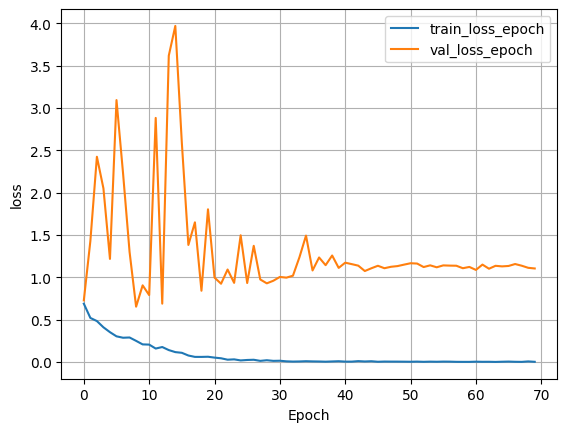

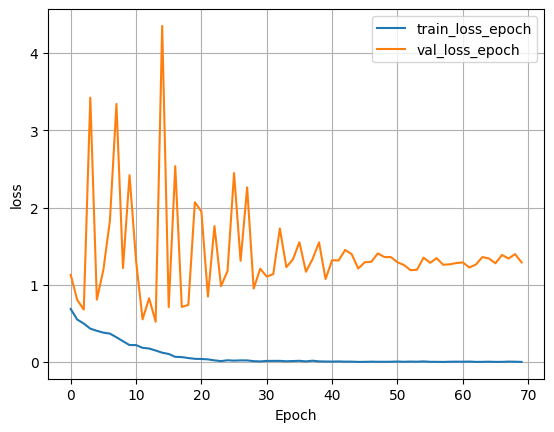

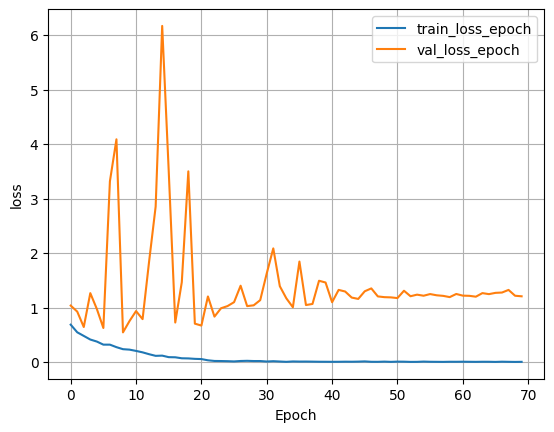

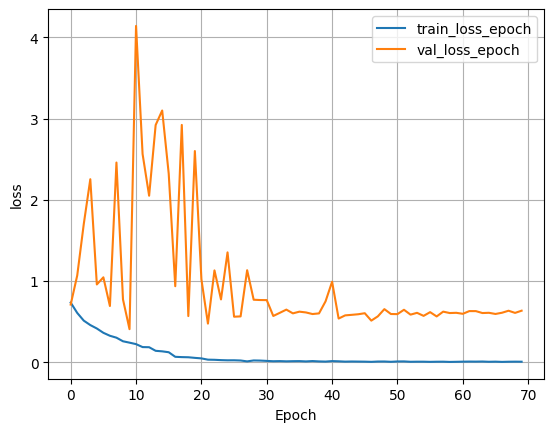

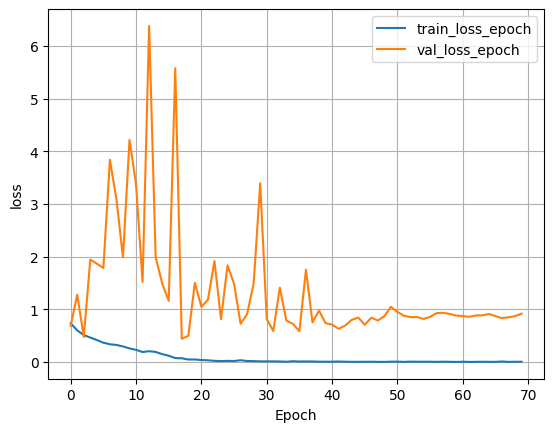

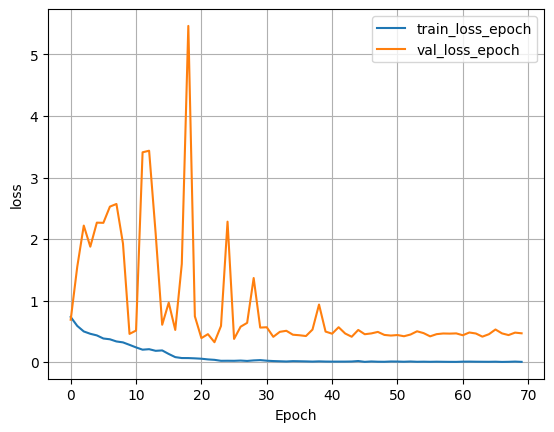

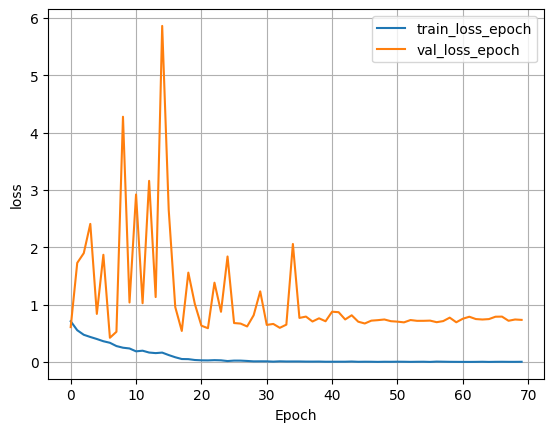

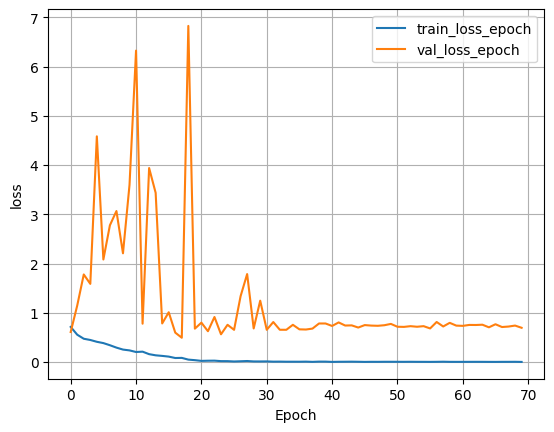

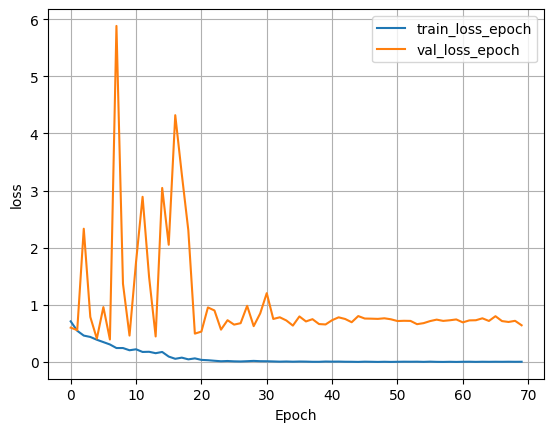

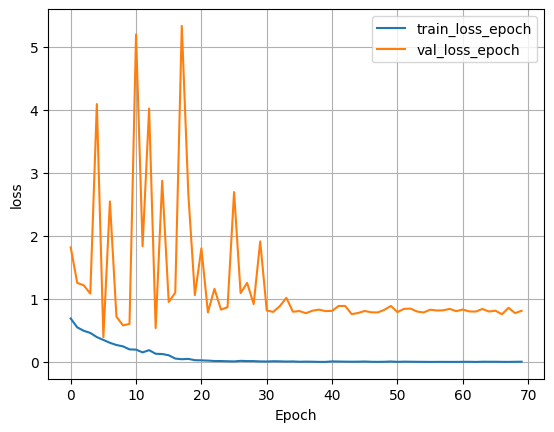

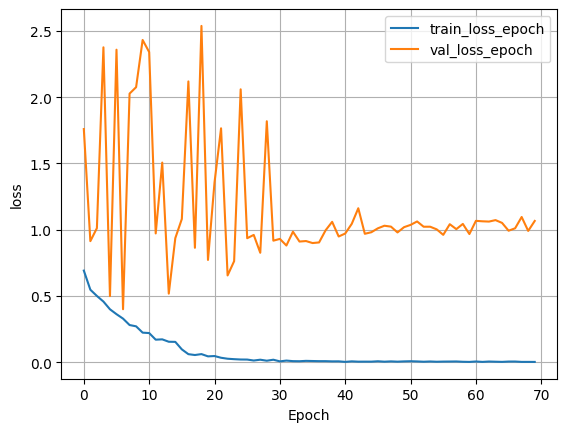

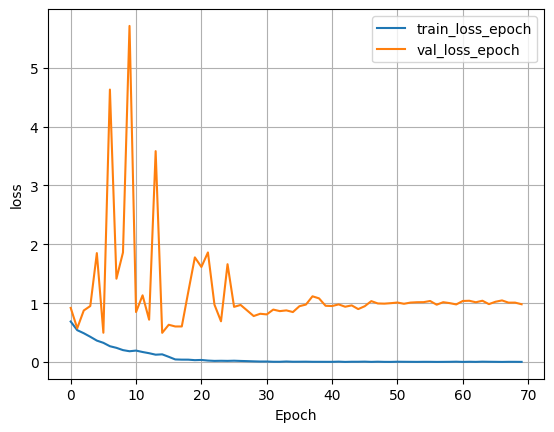

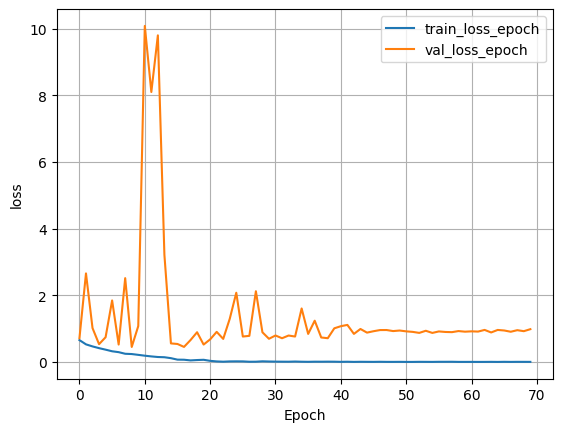

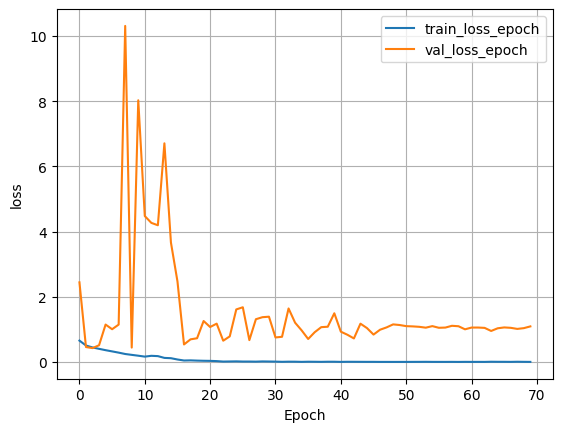

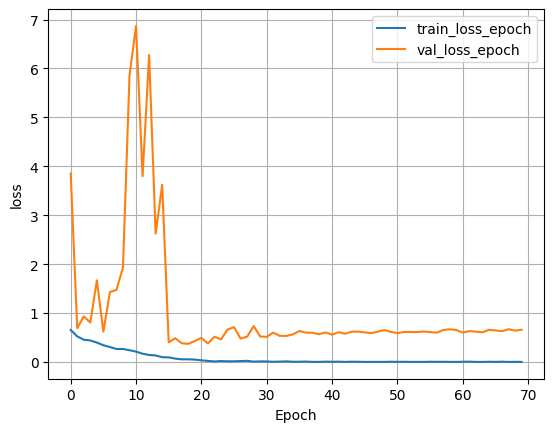

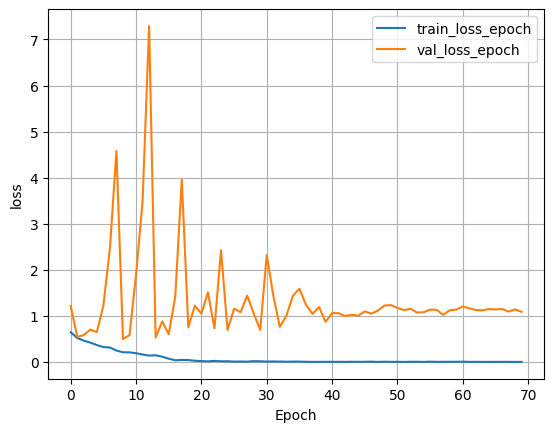

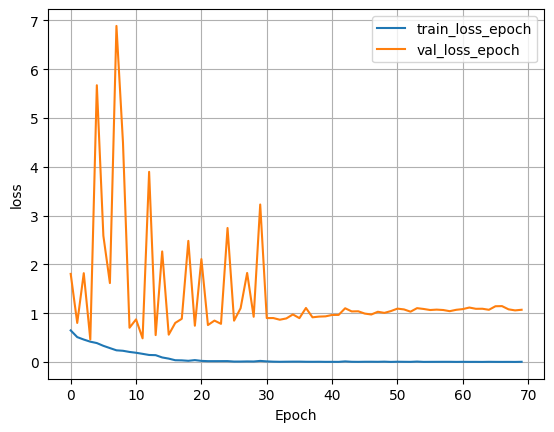

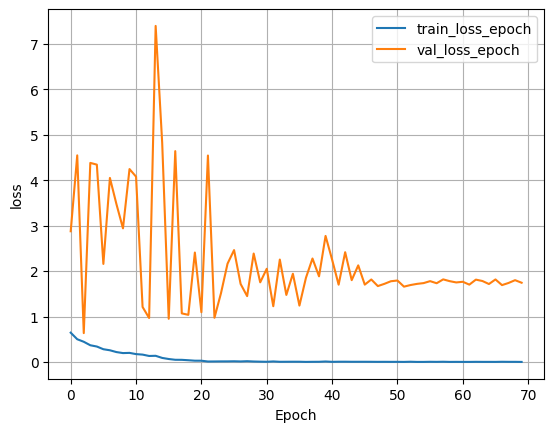

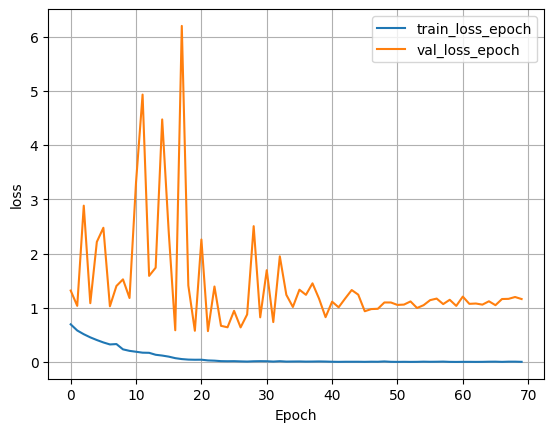

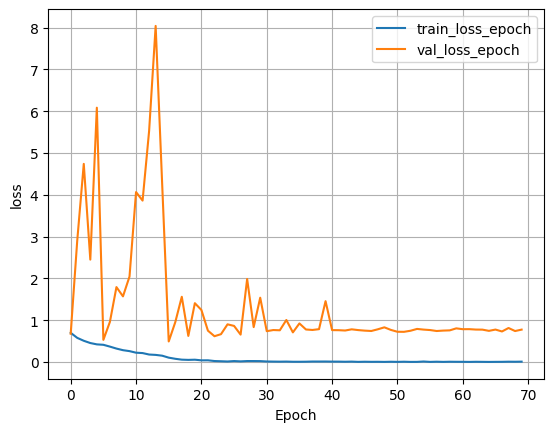

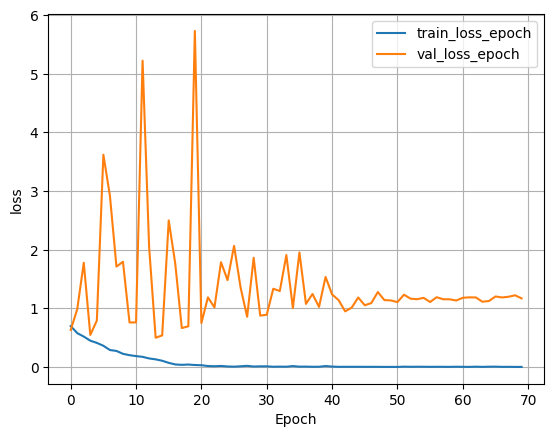

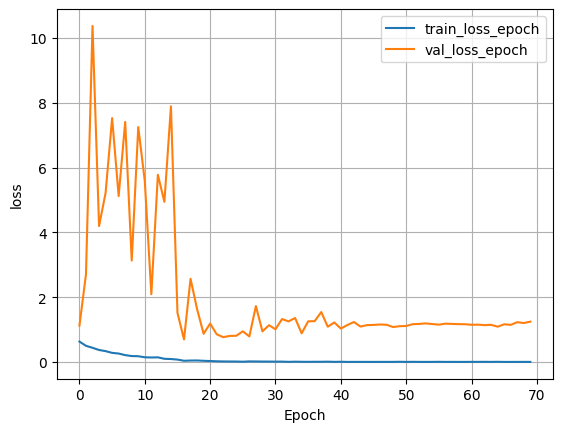

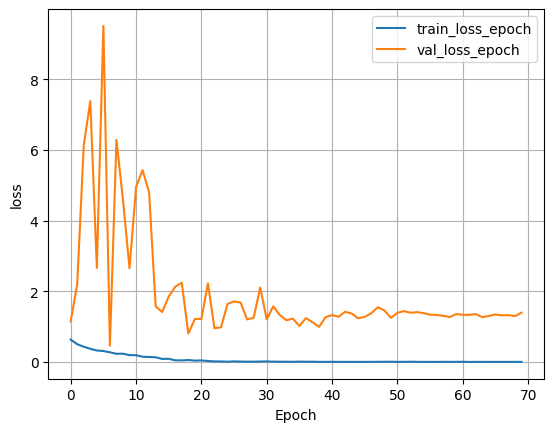

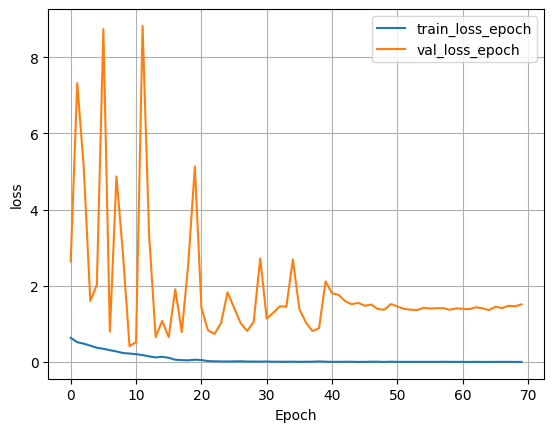

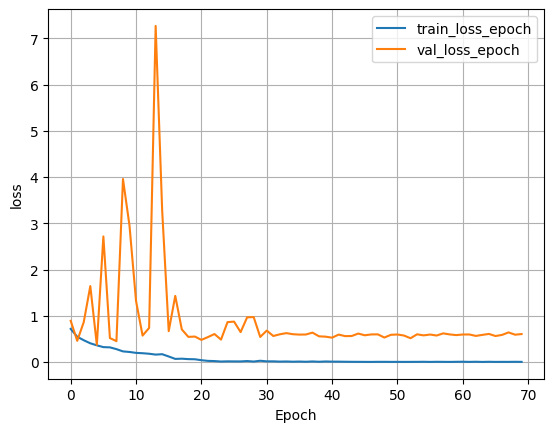

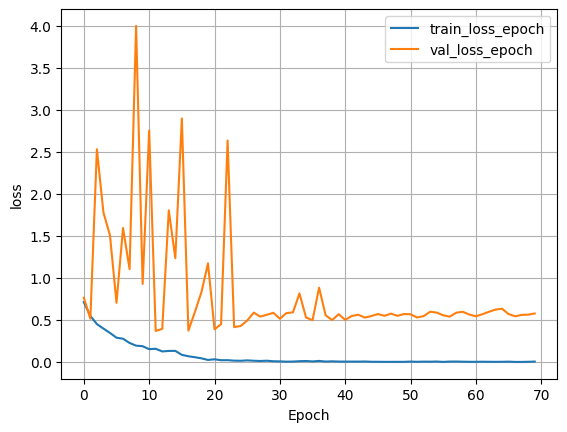

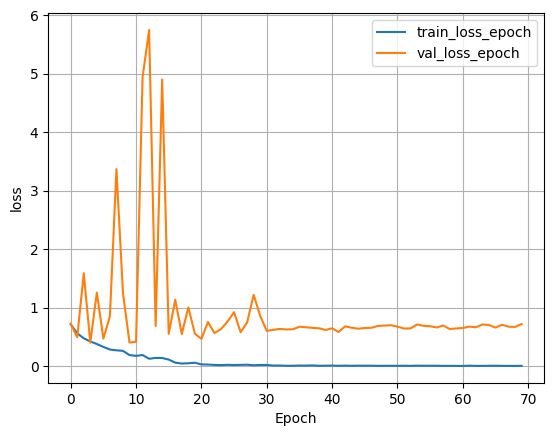

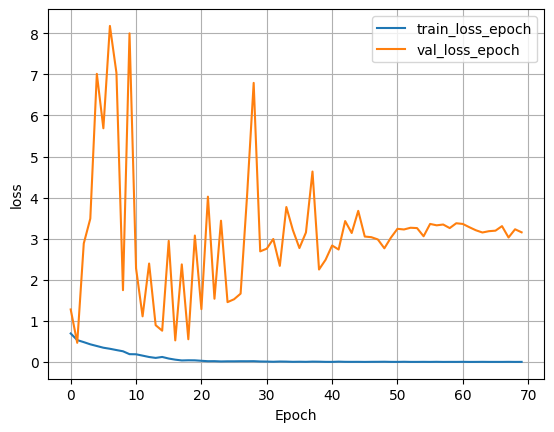

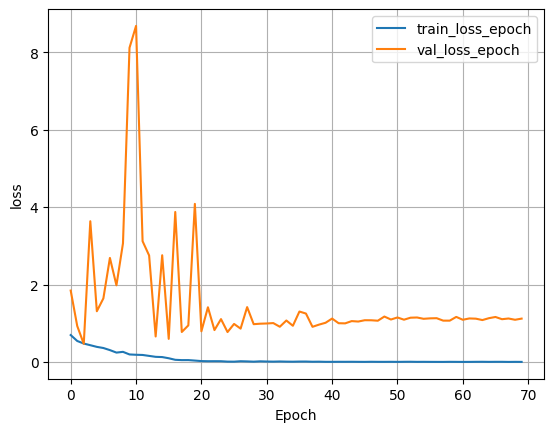

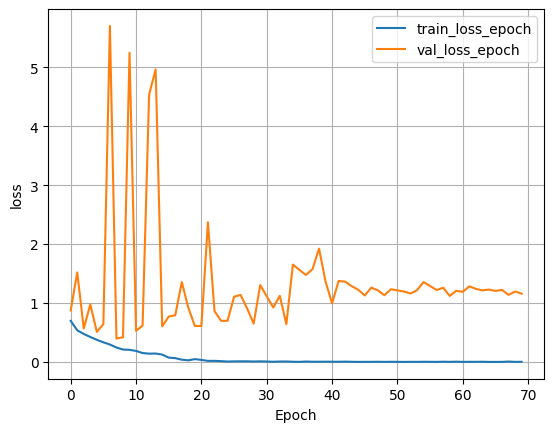

In [59]:
for i in range(10):
    train_dataset.set_active_fold(i)
    test_dataset.set_active_fold(i)
    # max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
    train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    # for sp1 in [True, False]:
    #     for sp2 in [True, False]:
    #         for sp3 in [True, False]:
    sp1, sp2, sp3 = False, True, True
    for j in range(3):
        model_manager = train_model(70, 0.2, 0.000012, 0.0032, use_token_polarity=[sp1, sp2, sp3])
        time.sleep(20)
        torch.cuda.empty_cache()
        import gc
        gc.collect()
        time.sleep(20)

In [61]:
def calculatge_metrics(chpt_path, target_data_loader, use_token_polarity=[False, False, False]):
        classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_token_polarity=use_token_polarity)
        classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(chpt_path, model=classifier_torch_model, num_classes=len(class_id)).eval()
        mean_infer_acc = []
        mean_infer_f1 = []
        mean_infer_prec = []
        mean_infer_rec = []
        for i in range(5):
            all_ys = []
            all_y_preds = []
            for X, y in target_data_loader:
                with torch.no_grad():
                    y_pred = classfier_lightning_model(X.to(device))
                all_ys.append(torch.argmax(y,dim=1))
                all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
            all_ys = torch.concat(all_ys)
            all_y_preds = torch.concat(all_y_preds)
            
            cm = confusion_matrix(all_ys, all_y_preds)
            
            accuracy = np.sum(np.diag(cm))/ np.sum(cm)
            precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
            recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
            f1_score = (2*precision*recall)/(precision + recall)
            
            mean_infer_acc.append(accuracy)
            mean_infer_f1.append(f1_score)
            mean_infer_prec.append(precision)
            mean_infer_rec.append(recall)
        mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
        mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
        mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
        mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
        return mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec

In [62]:
from os import listdir
from os.path import isfile, join
def get_best_chpt(metrics_path, epoch_numbers):
    epoch_data = pd.read_csv(metrics_path)
    if 'val_acc_epoch' in epoch_data.columns and epoch_data['val_acc_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_acc_epoch'].idxmax()]
    elif 'val_loss_epoch' in epoch_data.columns and epoch_data['val_loss_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_loss_epoch'].idxmin()]
    else:
        raise ValueError(f"No valid validation metrics available for epoch {epoch_numbers}.")
    return np.argwhere(np.array(epoch_numbers)==best_chpt['epoch']).item(), best_chpt['val_loss_epoch']

In [65]:
def calculate_average_metrics_mean(base_path = 'logs\CNN-GNN18_mr2k_seeds', use_token_polarity=[False, False, False]):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []

    for k_fold_num in range(10):
        infer_acc, infer_f1, infer_prec, infer_rec, infer_loss = [], [], [], [], []
        for j in range(3):
            i = k_fold_num*3 + j
            # k_fold_num = i//3
            test_dataset.set_active_fold(k_fold_num)
            test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
            
            version_path = join(base_path, f'version_{i}')
            checkpoint_path = join(version_path, f'checkpoints')
            onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
            epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
            best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
            print(onlyfiles[best_chpt_id])
            mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader, use_token_polarity=use_token_polarity)
                
            infer_acc.append(mean_infer_acc)
            infer_f1.append(mean_infer_f1)
            infer_prec.append(mean_infer_prec)
            infer_rec.append(mean_infer_rec)
            infer_loss.append(loss)

        total_accuracy.append(torch.mean(torch.tensor(infer_acc)))
        total_f1.append(torch.mean(torch.tensor(infer_f1)))
        total_prec.append(torch.mean(torch.tensor(infer_prec)))
        total_rec.append(torch.mean(torch.tensor(infer_rec)))
        total_loss.append(torch.mean(torch.tensor(infer_loss)))

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')

In [64]:
def calculate_average_metrics_max(base_path = 'logs\CNN-GNN18_mr2k_seeds', use_token_polarity=[False, False, False]):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []

    for k_fold_num in range(10):
        infer_acc, infer_f1, infer_prec, infer_rec, infer_loss = [], [], [], [], []
        for j in range(3):
            i = k_fold_num*3 + j
            # k_fold_num = i//3
            test_dataset.set_active_fold(k_fold_num)
            test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
            
            version_path = join(base_path, f'version_{i}')
            checkpoint_path = join(version_path, f'checkpoints')
            onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
            epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
            best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
            print(onlyfiles[best_chpt_id])
            mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader, use_token_polarity=use_token_polarity)
                
            infer_acc.append(mean_infer_acc)
            infer_f1.append(mean_infer_f1)
            infer_prec.append(mean_infer_prec)
            infer_rec.append(mean_infer_rec)
            infer_loss.append(loss)

        total_accuracy.append(torch.max(torch.tensor(infer_acc)))
        total_f1.append(torch.max(torch.tensor(infer_f1)))
        total_prec.append(torch.max(torch.tensor(infer_prec)))
        total_rec.append(torch.max(torch.tensor(infer_rec)))
        total_loss.append(torch.min(torch.tensor(infer_loss)))

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')

In [1]:
calculate_average_metrics_mean(r'logs\CNN-GNN_True_True_True', [True, True, True])

NameError: name 'calculate_average_metrics_mean' is not defined

In [2]:
calculate_average_metrics_mean(r'logs\CNN-GNN_True_True_False', [True, True, False])

NameError: name 'calculate_average_metrics_mean' is not defined

In [3]:
calculate_average_metrics_mean(r'logs\CNN-GNN_True_False_True', [True, False, True])

NameError: name 'calculate_average_metrics_mean' is not defined

In [4]:
calculate_average_metrics_mean(r'logs\CNN-GNN_True_False_False', [True, False, False])

NameError: name 'calculate_average_metrics_mean' is not defined

In [66]:
calculate_average_metrics_mean(r'logs\CNN-GNN_False_True_True', [False, True, True])

epoch=57-step=2088.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=18-step=684.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=43-step=1584.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=33-step=1224.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=41-step=1512.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=22-step=828.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=68-step=2484.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=30-step=1116.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=26-step=972.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=68-step=2484.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=52-step=1908.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=28-step=1044.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=16-step=612.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=35-step=1296.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=19-step=720.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=32-step=1188.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=37-step=1368.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=22-step=828.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=26-step=972.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=61-step=2232.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=42-step=1548.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=34-step=1260.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=35-step=1296.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=9-step=360.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=48-step=1764.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=24-step=900.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=46-step=1692.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=16-step=612.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=15-step=576.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=33-step=1224.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


total_accuracy: 0.8670666666666668
total_f1: 0.8678428132836743
total_prec: 0.8688820550148693
total_rec: 0.8668143184148376
total_loss: 0.7205312818288803


In [6]:
calculate_average_metrics_mean(r'logs\CNN-GNN_False_True_False', [False, True, False])

NameError: name 'calculate_average_metrics_mean' is not defined

In [7]:
calculate_average_metrics_mean(r'logs\CNN-GNN_False_False_True', [False, False, True])

NameError: name 'calculate_average_metrics_mean' is not defined

In [8]:
calculate_average_metrics_mean(r'logs\CNN-GNN_False_False_False', [False, False, False])

NameError: name 'calculate_average_metrics_mean' is not defined

In [11]:
p=85.78
r=86.06
2*p*r/(p+r)

85.91977188081937